In [79]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from scipy.integrate import simps
from scipy.special import hyp1f1
from naima.models import TableModel
from naima.models import InverseCompton
import matplotlib.pyplot as plt 
import os

m_e = (const.m_e.cgs).value
c= (const.c.cgs).value
e = (const.e.esu).value
sigma_sb = (const.sigma_sb.cgs).value
pi = np.pi
Lam_max = (1e18*(u.cm)).value

In [ ]:
datadir = '/home/wsy/V4641_Sgr/data/'
file1 = np.loadtxt(datadir+'HAWC.txt') 
file2 = np.loadtxt(datadir+'LHAASO.txt') 
file3 = np.loadtxt(datadir+'HESS.txt') 
# HAWC, in TeV
x1 = (file1[1:,0]*(u.TeV)).value
y1 = ((file1[1:,1]*(u.TeV)).to(u.erg)).value
upper1 = ((file1[1:,2]*(u.TeV)).to(u.erg)).value
lower1 = ((-file1[1:,3]*(u.TeV)).to(u.erg)).value
error_limit1 = [lower1, upper1]
err1 = (upper1+lower1)/2
a1 = np.column_stack((x1,y1,err1))
#LHAASO,in TeV
x2 = (file2[2:,0]*(u.TeV)).value
y2 = ((file2[2:,1]*(u.TeV)).to(u.erg)).value
upper2 = ((file2[2:,2]*(u.TeV)).to(u.erg)).value
lower2 = ((file2[2:,3]*(u.TeV)).to(u.erg)).value
error_limit2 = [lower2, upper2]
err2 = (upper2+lower2)/2
a2 = np.column_stack((x2,y2,err2))
# HESS, in erg
x3 = (file3[:,0]*(u.TeV)).value
y3 = ((file3[:,1]*(u.erg))).value
upper3 = (file3[:,2]*(u.erg)).value
lower3 = (file3[:,3]*(u.erg)).value
error_limit3 = [lower3, upper3]
err3 = (upper3+lower3)/2
a3 = np.column_stack((x3,y3,err3))
a_all = np.row_stack((a1,a2,a3))
sorted_a_all = a_all[np.argsort(a_all[:, 0])]

ene_obs = np.float64(sorted_a_all[:,0])
flux_obs = np.float64(sorted_a_all[:,1])
err_obs = np.float64(sorted_a_all[:,2])
if np.any(np.isnan(flux_obs)) or np.any(np.isnan(1/err_obs)):
    raise ValueError("观测数据包含 NaN 值")

In [81]:
# Single shear acc electron spectrum model
def SEPL(lgB,Reg,beta,lgN):
    B0=(((10**lgB)*(u.uG)).to(u.G)).value
    Reg_sh = ((Reg*(u.pc)).cgs).value
    beta = beta
    N_tot = 10**lgN # Normalization index, 10**Norm_A
    Lam_max = (1e18*(u.cm)).value
    z=0
    xi=1
    q=5/3

    Gamma_j = (1/(4*np.square(beta)))*np.square(np.log((1+beta)/(1-beta))) # averaged bulk lorentz factor
    Grad = beta/Reg_sh
    D_sh = (2/15)*Gamma_j*np.square(c)*np.square(Grad)
    sigma_e = (8*np.pi/3)*np.square(e**2/(m_e*c**2)) # cross section of electrons
    T_cmb = 2.72 # CMB temperature
    U_B = np.square(B0)/8*np.pi

    U_cmb = ((4*sigma_sb)/c)*T_cmb**4*(1+z)**4 # only CMB is considered
    U_rad = U_cmb

    A1 = D_sh*xi**(-1)*(Lam_max/c)**(q-1)*(m_e*c/(e*B0))**(2-q)
    A2 = (sigma_e*B0**2*(1+U_rad/U_B))/(6*np.pi*m_e*c)
    gamma_max = (((6-q)/2)*(A1/A2))**(1/(q-1))
    gamma_cut = 10*gamma_max # n(10γ_max)=0
    E_cut=(((gamma_cut*m_e*c**2)*(u.erg)).to(u.eV)).value
    lgcut = np.log10(E_cut)

    if(lgcut<=12):
        return np.zeros(1)-np.inf
    
    z_cut=((6-q)/(1-q))*(gamma_cut/gamma_max)**(q-1)
    w = 40/np.square(np.log((1+beta)/(1-beta)))
    s1 = (q-1)/2+np.sqrt((5-q)**2/4+w)
    s2 = (q-1)/2-np.sqrt((5-q)**2/4+w)
    a1 = (2+s1)/(q-1)
    a2 = (2+s2)/(q-1)
    b1 = (2*s1)/(q-1)
    b2 = (2*s2)/(q-1)
    C2 = 1
    C1 = -C2*gamma_cut**(s2-s1)*(hyp1f1(a2,b2,z_cut)/hyp1f1(a1,b1,z_cut))

    E_all = (np.logspace(12,lgcut,1000)*(u.eV)).to(u.erg) # selected energy range
    gamma_all = (E_all.value)/(m_e*np.square(c)) #10**np.arange(min,max,0.1)
    mask = np.where(gamma_all<=gamma_cut) # cutoff energy
    gamma_all = gamma_all[mask]
    z=((6-q)/(1-q))*(gamma_all/gamma_max)**(q-1)
    n_all = C1*gamma_all**s1*hyp1f1(a1,b1,z)+C2*gamma_all**s2*hyp1f1(a2,b2,z)
    mask1 = np.where(n_all>0)
    n_all=n_all[mask1]
    gamma_all = gamma_all[mask1]

    length = len(n_all)
    if (length<=5):
        return np.zeros(1)-np.inf
    ene_eV = ((gamma_all*m_e*c**2)*(u.erg)).to(u.eV) # energy in eV
    n_eV = n_all/((m_e*c**2)*(u.erg)).to(u.eV) # number density(1/eV)
    N_A = simps(n_all, gamma_all)
    n_all=N_tot*n_all/N_A
    n_eV = n_eV/N_A

    EC = TableModel(ene_eV,n_eV)
    IC = InverseCompton(EC,seed_photon_fields=['CMB'],Eemax = 1e18*(u.eV))
    spectrum_energy_ic = ene_obs*(u.TeV) # observed energies
    sed_IC = IC.sed(spectrum_energy_ic,distance=6.6*u.kpc) # erg/s
    sed_IC=N_tot*(sed_IC.value) # number of particles:10**lgN
   

    return sed_IC


In [82]:
# Combined spectrum model of stochastic and shear acceleration
def SSEPL(lgB,Reg,beta,lgN,lgrho):
    B0=(((10**lgB)*(u.uG)).to(u.G)).value
    Reg_sh = ((Reg*(u.pc)).cgs).value
    beta = beta
    N_tot = 10**lgN # Normalization index, 10**Norm_A
    rho = 10**lgrho
    Lam_max = (1e18*(u.cm)).value
    z=0
    xi=1
    q=5/3
    Delta_r = Reg_sh
    Gamma_j = (1/(4*np.square(beta)))*np.square(np.log((1+beta)/(1-beta))) # averaged bulk lorentz factor
    Grad=beta/Delta_r
    
    # calculate the maximum energy for stochastic acc
    beta_Alf = (B0/np.sqrt(4*pi*rho))/c # Alfven velocity
    Gamma_Alf = 1/np.sqrt(1-beta_Alf**2)
    gamma_st = ((15*(q+2)/(2*(6-q)))*(Gamma_Alf**2*(np.square(xi*Gamma_Alf*beta_Alf))/(Lam_max**(2*q-2)*np.square(Gamma_j**2*Grad))))**(1/(4-2*q))*(e*B0/(m_e*np.square(c)))
    E_st = (((gamma_st*m_e*c**2)*(u.erg)).to(u.eV)).value
    lgE_st = np.log10(E_st)
    
    # This part is for the shearing spectrum
    D_sh = (2/15)*Gamma_j*np.square(Grad*c)
    sigma_e = (8*np.pi/3)*np.square(e**2/(m_e*c**2)) # cross section of electrons
    T_cmb = 2.72 # CMB temperature
    U_B = np.square(B0)/8*np.pi
    U_cmb = ((4*sigma_sb)/c)*T_cmb**4*(1+z)**4 # only CMB is considered
    U_rad = U_cmb
    A1 = D_sh*xi**(-1)*(Lam_max/c)**(q-1)*(m_e*c/(e*B0))**(2-q)
    A2 = (sigma_e*B0**2*(1+U_rad/U_B))/(6*np.pi*m_e*c)
    gamma_max = (((6-q)/2)*(A1/A2))**(1/(q-1))
    gamma_cut = 10*gamma_max # n(10γ_max)=0
    E_cut=(((gamma_cut*(m_e*c**2))*(u.erg)).to(u.eV)).value
    lgE_cut = np.log10(E_cut)
    z_cut=((6-q)/(1-q))*(gamma_cut/gamma_max)**(q-1)
    w = 40/np.square(np.log((1+beta)/(1-beta)))
    s1 = (q-1)/2+np.sqrt((5-q)**2/4+w)
    s2 = (q-1)/2-np.sqrt((5-q)**2/4+w)
    a1 = (2+s1)/(q-1)
    a2 = (2+s2)/(q-1)
    b1 = (2*s1)/(q-1)
    b2 = (2*s2)/(q-1)
    C2 = 1
    C1 = -C2*gamma_cut**(s2-s1)*(hyp1f1(a2,b2,z_cut)/hyp1f1(a1,b1,z_cut))

    # electron spec for shearing acc, the spectrum should begin at lower energies to ensure the number of particles
    if(lgE_st<=9) or (lgE_st>=lgE_cut):
        return np.zeros(1)-np.inf
    
    E_sh = (np.logspace(lgE_st,lgE_cut,1000)*(u.eV)).to(u.erg) # selected energy range(TeV)
    gamma_sh = (E_sh.value)/(m_e*np.square(c)) 
    mask = np.where(gamma_sh<=gamma_cut) # cutoff energy
    gamma_sh = gamma_sh[mask]
    z=((6-q)/(1-q))*(gamma_sh/gamma_max)**(q-1)
    n = C1*gamma_sh**s1*hyp1f1(a1,b1,z)+C2*gamma_sh**s2*hyp1f1(a2,b2,z)
    mask1 = np.where(n>0)
    n=n[mask1]
    gamma_sh = gamma_sh[mask1]


    # electron spec for stochastic acc
    E_low = (np.logspace(9,lgE_st,1000)*(u.eV)).to(u.erg)
    gamma_low = (E_low.value)/(m_e*np.square(c))
    N0 = n[0]/(gamma_low[-1])**(1-q)
    n_low = N0*gamma_low**(1-q)

    # Connect the spectrum and do the normalization

    gamma_all = np.append(gamma_low[:-1],gamma_sh)
    n_all = np.append(n_low[:-1],n)
    length = len(n_all)
    if (length<=5):
        return np.zeros(1)-np.inf

    ene_eV = ((gamma_all*m_e*c**2)*(u.erg)).to(u.eV) # energy in eV
    n_eV = n_all/((m_e*c**2)*(u.erg)).to(u.eV) # number density(1/eV)

    N_A = simps(n_all, gamma_all)
    n_all=N_tot*n_all/N_A
    n_eV = n_eV/N_A

    EC = TableModel(ene_eV,n_eV)
    IC = InverseCompton(EC,seed_photon_fields=['CMB'],Eemax = 1e18*(u.eV))
    spectrum_energy_ic = ene_obs*(u.TeV) # observed energies
    sed_IC = IC.sed(spectrum_energy_ic,distance=6.6*u.kpc) # erg/s
    sed_IC=N_tot*(sed_IC.value) # number of particles:10**lgN
   
    return sed_IC

9.701068669248269


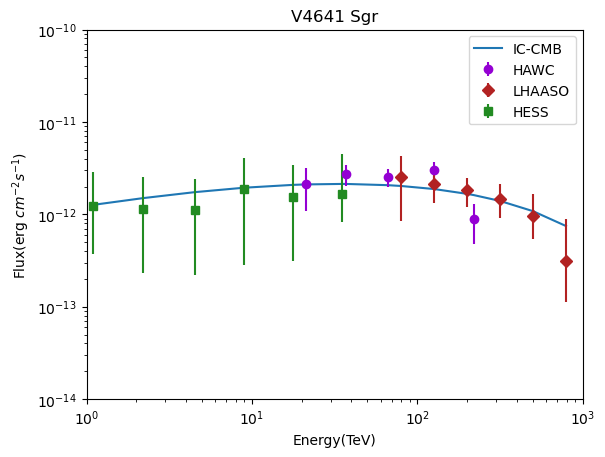

In [ ]:
lgB=0.92
Reg=2.34
beta=0.910
lgN=46.643
spectrum_energy_ic = ene_obs*(u.TeV)
sed_IC = SEPL(lgB,Reg,beta,lgN)
plt.figure()
plt.title('V4641 Sgr')
plt.semilogx()
plt.semilogy()
plt.xlim(1e0,1000)
plt.ylim(1e-14,1e-10)
plt.xlabel('Energy(TeV)')
plt.ylabel(r'Flux(erg $cm^{-2}s^{-1}$)')
plt.plot(spectrum_energy_ic,sed_IC,label = 'IC-CMB')
plt.errorbar(x1,y1,c='darkviolet',fmt = 'o', yerr = error_limit1,ls='None',label = 'HAWC')
plt.errorbar(x2,y2,c='firebrick',fmt = 'D', yerr = error_limit2,ls='None',label = 'LHAASO')
plt.errorbar(x3,y3,c='forestgreen',fmt = 's', yerr = error_limit3,ls='None',label = 'HESS')
plt.legend()

# calculate chi2
chi2 = np.sum((sed_IC-flux_obs)**2/err_obs**2)
print(chi2)

'''new_folder = "run1_s"
path ='E:\V4641_Sgr\\results\\fits'
os.chdir(path)
os.makedirs(new_folder)
plt.savefig(path+'\\'+new_folder+'\\lgB0=%s_R=%s_beta=%s_lgN=%s_chi2=%s_weighted.png'%(lgB,Reg,beta,lgN,chi2))'''
plt.show()

9.07077351521561


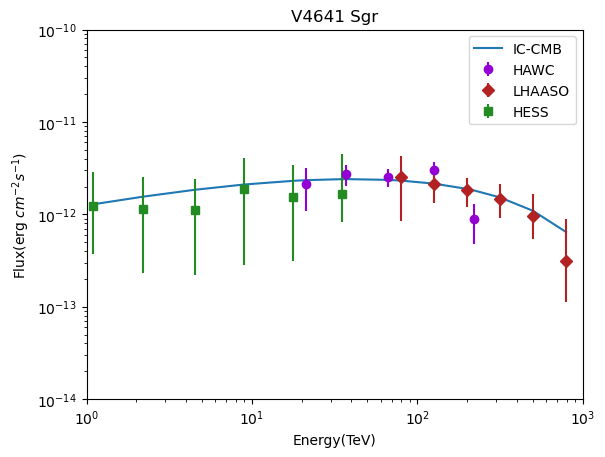

In [ ]:
lgB=0.998
Reg=2.35
beta=0.92
lgN=49.12   #45.425
lgrho=-28   #-30
spectrum_energy_ic = ene_obs*(u.TeV)
sed_IC = SSEPL(lgB,Reg,beta,lgN,lgrho)
plt.figure()
plt.title('V4641 Sgr')
plt.semilogx()
plt.semilogy()
plt.xlim(1e0,1000)
plt.ylim(1e-14,1e-10)
plt.xlabel('Energy(TeV)')
plt.ylabel(r'Flux(erg $cm^{-2}s^{-1}$)')
plt.plot(spectrum_energy_ic,sed_IC,label = 'IC-CMB')
plt.errorbar(x1,y1,c='darkviolet',fmt = 'o', yerr = error_limit1,ls='None',label = 'HAWC')
plt.errorbar(x2,y2,c='firebrick',fmt = 'D', yerr = error_limit2,ls='None',label = 'LHAASO')
plt.errorbar(x3,y3,c='forestgreen',fmt = 's', yerr = error_limit3,ls='None',label = 'HESS')
plt.legend()

# calculate chi2
chi2 = np.sum((sed_IC-flux_obs)**2/err_obs**2)
print(chi2)

'''new_folder = "run1_ss"
path ='E:\V4641_Sgr\\results\\fits'
os.chdir(path)
os.makedirs(new_folder)
plt.savefig(path+'\\'+new_folder+'\\lgB0=%s_R=%s_beta=%s_lgN=%s_lgrho=%s_chi2=%s_weighted.png'%(lgB,Reg,beta,lgN,lgrho,chi2))'''
plt.show()